In [1]:
import sys
import os
import glob 

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy as sc

import plotly.express as px
import plotly.graph_objects as go

import collections

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split

import tensorflow as tf
from sklearn.preprocessing import StandardScaler

2025-10-12 19:13:13.090370: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
derived_path = "/cluster/home/taoj/work_dir/eth-capstone/tree-water-deficit/data"
data_dir = "/cluster/home/taoj/work_dir/eth-caipstone/tree-water-deficit/data/tstoy04"

In [3]:
df_series_all = pd.read_csv(os.path.join(derived_path, "twd_tree_series_all.csv"))
twd_tree_series_sites = pd.read_csv(os.path.join(derived_path, "twd_tree_series_sites.csv"))

In [4]:
df_series_all.head(10)
# twd_tree_series_sites.head(10)

,ts,twd,pr,at,ws,dp,sr,lr,series,site_name,species,series_no,Wt,year,month,year_month
0,2020-01-01,0.000000,-4.967054e-09,0.684757,1.197186,-3.640214,62.291590,212.325577,series_06,Bachtel-Forest,Fagus sylvatica,1,NaN,2020,1,2020-01
1,2020-01-02,0.121408,-1.092752e-07,0.213088,1.312338,-4.036302,60.923900,219.828021,series_06,Bachtel-Forest,Fagus sylvatica,1,0.121408,2020,1,2020-01
2,2020-01-03,0.118271,1.285767e-01,2.009851,2.115951,-0.953911,55.859708,275.925156,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.003137,2020,1,2020-01
3,2020-01-04,0.000000,9.927122e-02,1.573278,3.247398,0.721803,13.914832,311.878969,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.118271,2020,1,2020-01
4,2020-01-05,0.000000,-1.986821e-08,-0.442240,2.159941,-4.094125,62.620516,216.038632,series_06,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01
5,2020-01-06,0.000000,3.880511e-10,1.900865,1.479226,-5.472837,63.572741,220.306782,series_06,Bachtel-Forest,Fagus sylvatica,1,0.000000,2020,1,2020-01
6,2020-01-07,0.593406,2.411429e-02,1.480216,2.514120,-1.105571,26.014536,265.315427,series_06,Bachtel-Forest,Fagus sylvatica,1,0.593406,2020,1,2020-01
7,2020-01-08,0.557187,-6.457170e-07,3.140700,2.099829,-7.224881,48.464034,265.264362,series_06,Bachtel-Forest,Fagus sylvatica,1,-0.036220,2020,1,2020-01
8,2020-01-09,0.918142,-1.182159e-06,5.119999,1.631017,-5.251706,58.383674,248.506977,series_06,Bachtel-Forest,Fagus sylvatica,1,0.360955,2020,1,2020-01
9,2020-01-10,1.269509,5.132516e-03,3.655803,3.022984,-0.587912,39.215077,289.792323,series_06,Bachtel-Forest,Fagus sylvatica,1,0.351367,2020,1,2020-01


start from simple model 
- understand the covariance, mean a little better
- gaussian process
- autoregressive model 

1. autoregressive

Augmented Dickey-Fuller Test table
https://support.minitab.com/en-us/minitab/help-and-how-to/statistical-modeling/time-series/how-to/augmented-dickey-fuller-test/interpret-the-results/all-statistics-and-graphs/

In [5]:
df_series_1 = df_series_all.loc[(df_series_all.series_no == 1) & (df_series_all.year == 2020), ]
result = adfuller(df_series_1["twd"], autolag = 'AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -2.2298507542951334
p-value: 0.19559025445301198
Critial Values:
   1%, -3.4491725955218655
Critial Values:
   5%, -2.8698334971428574
Critial Values:
   10%, -2.5711883591836733


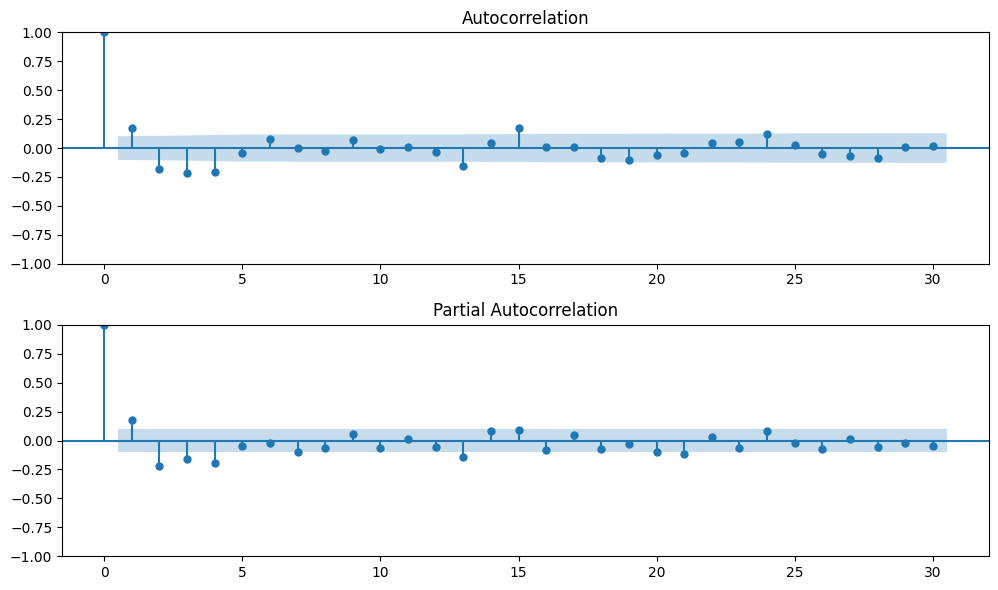

In [6]:
df_diff = df_series_1["twd"].diff().dropna()
fig, ax = plt.subplots(2,1, figsize=(10,6))
plot_acf(df_diff, lags=30, ax=ax[0])
plot_pacf(df_diff, lags=30, ax=ax[1])
plt.tight_layout()
plt.show()

it seems the lag can be 13... 
build an autoregressive model of 13 lags and exogenous values? 

data preparation

In [7]:

# Psudotsuga mnzisii", the same site "Multi-Forest" in 2021, 2022 exluded
df_series_all = df_series_all.loc[~((df_series_all.species == "Psudotsuga mnzisii") & (df_series_all.site_name == "Multi-Forest") & (df_series_all.year.isin([2021, 2022]))), ]
df_series_all_median = df_series_all.groupby(['site_name', 'species', 'ts']).agg({'twd': 'median',  'year': 'first',
                                                                                 'pr': 'median', 'at': 'median', "ws": 'median', 'dp': 'median',
                                                                                 'sr': 'median', 'lr':'median'}).reset_index() 

df_series_all_median= df_series_all_median.merge(twd_tree_series_sites[['site_name', 'species', 'mch_elevation', 'site_longitude', 'site_latitude']].drop_duplicates(), on=['site_name', 'species'], how='left')

In [8]:
# transform species to categorical variable - using ohe-hot encoding
# Get one hot encoding of columns B
one_hot = pd.get_dummies(df_series_all_median['species'],dtype=float)
# Drop column B as it is now encoded
df_series_all_features = df_series_all_median.drop('species',axis = 1)
# Join the encoded df
df_series_all_features = df_series_all_features.join(one_hot.iloc[: , 0:6])
# drop useless features 
df_series_features = df_series_all_features.drop(columns=['site_name', 'year', 'ts'])

In [9]:
df_series_features.head()

,twd,pr,at,ws,dp,sr,lr,mch_elevation,site_longitude,site_latitude,Carpinus betulus,Corylus avellana,Fagus sylvatica,Picea abies,Pinus sylvestris,Pseudotsuga menziesii
0,0.000000,-4.967054e-09,0.684757,1.197186,-3.640214,62.291590,212.325577,882.140575,8.89016,47.29413,0.0,0.0,1.0,0.0,0.0,0.0
1,0.121408,-1.092752e-07,0.213088,1.312338,-4.036302,60.923900,219.828021,882.140575,8.89016,47.29413,0.0,0.0,1.0,0.0,0.0,0.0
2,0.118271,1.285767e-01,2.009851,2.115951,-0.953911,55.859708,275.925156,882.140575,8.89016,47.29413,0.0,0.0,1.0,0.0,0.0,0.0
3,0.000000,9.927122e-02,1.573278,3.247398,0.721803,13.914832,311.878969,882.140575,8.89016,47.29413,0.0,0.0,1.0,0.0,0.0,0.0
4,0.000000,-1.986821e-08,-0.442240,2.159941,-4.094125,62.620516,216.038632,882.140575,8.89016,47.29413,0.0,0.0,1.0,0.0,0.0,0.0


split the data into training and test set
 - train and test set split by an even distribution of sites? 

In [10]:
column_indices = {name: i for i, name in enumerate(df_series_features.columns)}

n = len(df_series_features)
train_df = df_series_features[0:int(n*0.7)]
val_df = df_series_features[int(n*0.7):int(n*0.9)]
test_df = df_series_features[int(n*0.9):]

num_features = df_series_features.shape[1]

normalize certain colums: 

pr	at	ws	dp	sr	lr	mch_elevation	site_longitude	site_latitude

In [11]:
# Define columns to normalize
cols_to_normalize = ['pr', 'at', 'ws', 'dp', 'sr', 'lr', 
                    'mch_elevation', 'site_longitude', 'site_latitude']

# Initialize the scaler
scaler = StandardScaler()

# Fit and transform the training data
train_df[cols_to_normalize] = scaler.fit_transform(train_df[cols_to_normalize])

# Transform validation and test data using the same scaler
val_df[cols_to_normalize] = scaler.transform(val_df[cols_to_normalize])
test_df[cols_to_normalize] = scaler.transform(test_df[cols_to_normalize])

# Store scaler parameters for later use if needed
scaler_params = {
    'mean_': scaler.mean_,
    'scale_': scaler.scale_
}

/scratch/tmp.45601106.taoj/ipykernel_2962351/4077068060.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[cols_to_normalize] = scaler.fit_transform(train_df[cols_to_normalize])
/scratch/tmp.45601106.taoj/ipykernel_2962351/4077068060.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  val_df[cols_to_normalize] = scaler.transform(val_df[cols_to_normalize])
/scratch/tmp.45601106.taoj/ipykernel_2962351/4077068060.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a

In [12]:
# # test generating data windows
# class WindowGenerator():
#   def __init__(self, input_width, label_width, shift,
#                train_df=train_df, val_df=val_df, test_df=test_df,
#                label_columns=None):
#     # Store the raw data.
#     self.train_df = train_df
#     self.val_df = val_df
#     self.test_df = test_df

#     # Work out the label column indices.
#     self.label_columns = label_columns
#     if label_columns is not None:
#       self.label_columns_indices = {name: i for i, name in
#                                     enumerate(label_columns)}
#     self.column_indices = {name: i for i, name in
#                            enumerate(train_df.columns)}

#     # Work out the window parameters.
#     self.input_width = input_width
#     self.label_width = label_width
#     self.shift = shift

#     self.total_window_size = input_width + shift

#     self.input_slice = slice(0, input_width)
#     self.input_indices = np.arange(self.total_window_size)[self.input_slice]

#     self.label_start = self.total_window_size - self.label_width
#     self.labels_slice = slice(self.label_start, None)
#     self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

#   def __repr__(self):
#     return '\n'.join([
#         f'Total window size: {self.total_window_size}',
#         f'Input indices: {self.input_indices}',
#         f'Label indices: {self.label_indices}',
#         f'Label column name(s): {self.label_columns}'])


class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in
                                    enumerate(label_columns)}
    self.column_indices = {name: i for i, name in
                           enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [13]:
w1 = WindowGenerator(input_width=13, label_width=1, shift=1,
                     label_columns=['twd'])
w1

Total window size: 14
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Label indices: [13]
Label column name(s): ['twd']

In [14]:
# def split_window(self, features):
#     # Convert features to numpy if it's a tensor
#     if isinstance(features, tf.Tensor):
#         features = features.numpy()
        
#     inputs = features[self.input_slice, :]
#     labels = features[self.labels_slice, :]
    
#     if self.label_columns is not None:
#         # Extract only the columns we want to predict
#         label_indices = [self.column_indices[name] for name in self.label_columns]
#         labels = labels[:, label_indices]
    
#     # Ensure we have 2D arrays
#     inputs = inputs.reshape(inputs.shape[0], -1)  # Flatten the input window
#     labels = labels.reshape(labels.shape[0], -1)  # Flatten the label window
    
#     return inputs, labels

def split_window(self, features):
  inputs = features[:, self.input_slice, :]
  labels = features[:, self.labels_slice, :]
  if self.label_columns is not None:
    labels = tf.stack(
        [labels[:, :, self.column_indices[name]] for name in self.label_columns],
        axis=-1)

  # Slicing doesn't preserve static shape information, so set the shapes
  # manually. This way the `tf.data.Datasets` are easier to inspect.
  inputs.set_shape([None, self.input_width, None])
  labels.set_shape([None, self.label_width, None])

  return inputs, labels

WindowGenerator.split_window = split_window


w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                     label_columns=['twd'])



In [15]:
# # Stack three slices, the length of the total window.
# example_window = np.array(train_df[:w1.total_window_size])

# example_inputs, example_labels = w1.split_window(example_window)

# print('All shapes are: (batch, time, features)')
# print(f'Window shape: {example_window.shape}')
# print(f'Inputs shape: {example_inputs.shape}')
# print(f'Labels shape: {example_labels.shape}')


# Stack three slices, the length of the total window.
example_window = tf.stack([np.array(train_df[:w2.total_window_size]),
                           np.array(train_df[100:100+w2.total_window_size]),
                           np.array(train_df[200:200+w2.total_window_size])])

example_inputs, example_labels = w2.split_window(example_window)

print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window.shape}')
print(f'Inputs shape: {example_inputs.shape}')
print(f'Labels shape: {example_labels.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 7, 16)
Inputs shape: (3, 6, 16)
Labels shape: (3, 1, 1)


2025-10-12 19:13:18.723418: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [16]:
w2.example = example_inputs, example_labels
def plot(self, model=None, plot_col='twd', max_subplots=3):
  inputs, labels = self.example
  plt.figure(figsize=(12, 8))
  plot_col_index = self.column_indices[plot_col]
  max_n = min(max_subplots, len(inputs))
  for n in range(max_n):
    plt.subplot(max_n, 1, n+1)
    plt.ylabel(f'{plot_col}')
    plt.plot(self.input_indices, inputs[n,:, plot_col_index],
             label='Inputs', marker='.', zorder=-10)

    if self.label_columns:
      label_col_index = self.label_columns_indices.get(plot_col, None)
    else:
      label_col_index = plot_col_index

    if label_col_index is None:
      continue

    plt.scatter(self.label_indices, labels[n,:, label_col_index],
                edgecolors='k', label='Labels', c='#2ca02c', s=64)
    if model is not None:
      predictions = model(inputs)
      plt.scatter(self.label_indices, predictions[n,:, label_col_index],
                  marker='X', edgecolors='k', label='Predictions',
                  c='#ff7f0e', s=64)

    if n == 0:
      plt.legend()

  plt.xlabel('Time [D]')

WindowGenerator.plot = plot

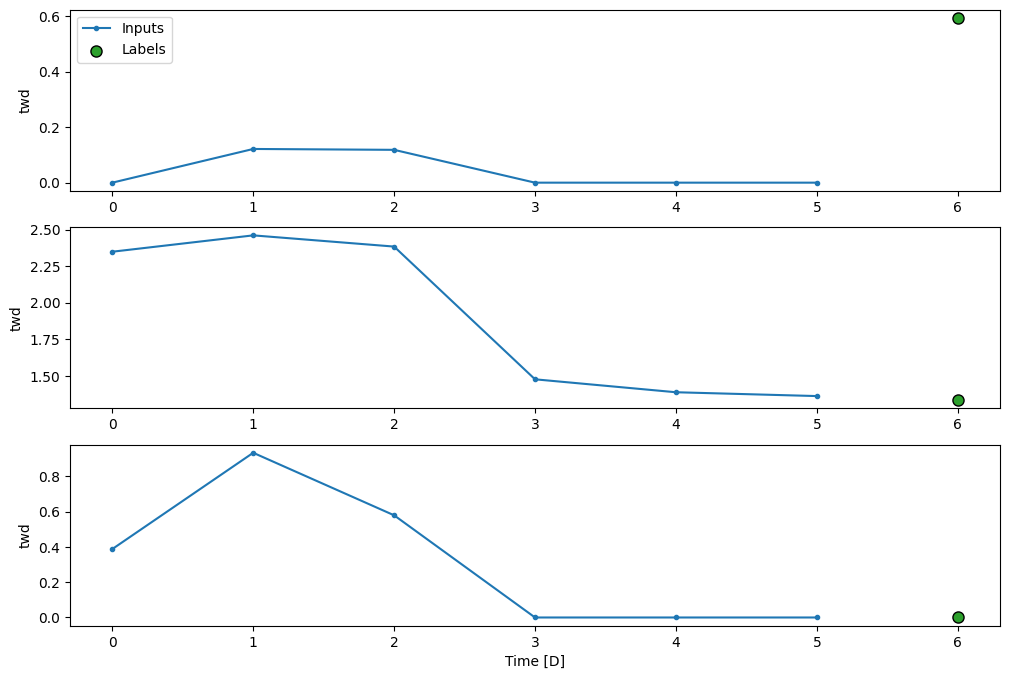

In [17]:
w2.plot(plot_col='twd')

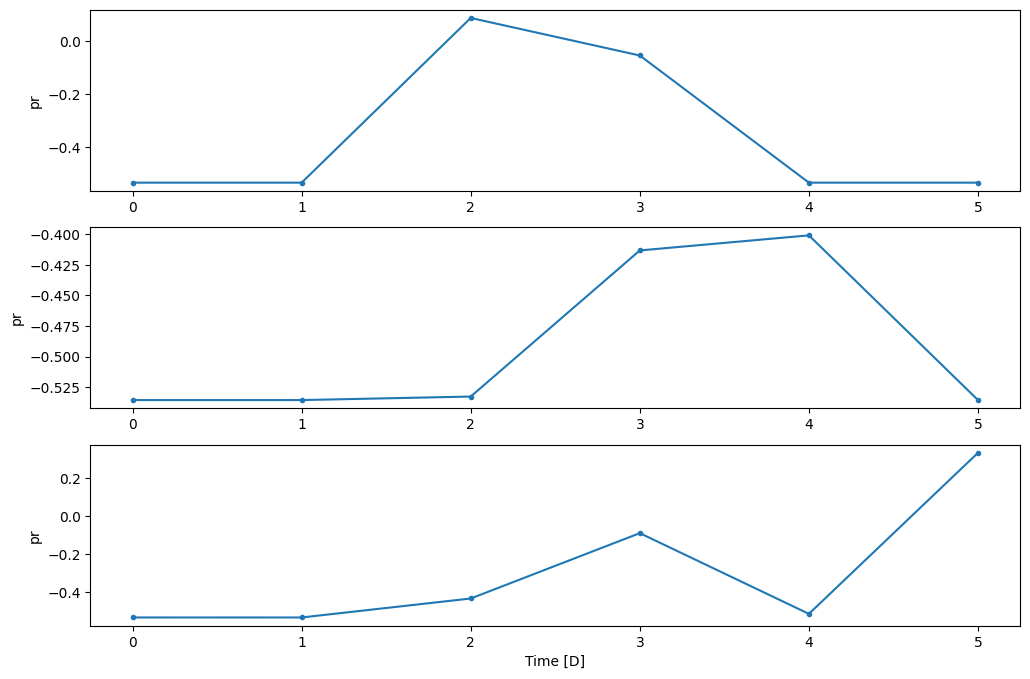

In [18]:
w2.plot(plot_col='pr')

In [19]:
def make_dataset(self, data):
  data = np.array(data, dtype=np.float32)
  ds = tf.keras.utils.timeseries_dataset_from_array(
      data=data,
      targets=None,
      sequence_length=self.total_window_size,
      sequence_stride=1,
      shuffle=True,
      batch_size=32,)

  ds = ds.map(self.split_window)

  return ds

WindowGenerator.make_dataset = make_dataset

In [20]:
@property
def train(self):
  return self.make_dataset(self.train_df)

@property
def val(self):
  return self.make_dataset(self.val_df)

@property
def test(self):
  return self.make_dataset(self.test_df)

@property
def example(self):
  """Get and cache an example batch of `inputs, labels` for plotting."""
  result = getattr(self, '_example', None)
  if result is None:
    # No example batch was found, so get one from the `.train` dataset
    result = next(iter(self.train))
    # And cache it for next time
    self._example = result
  return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [24]:
import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

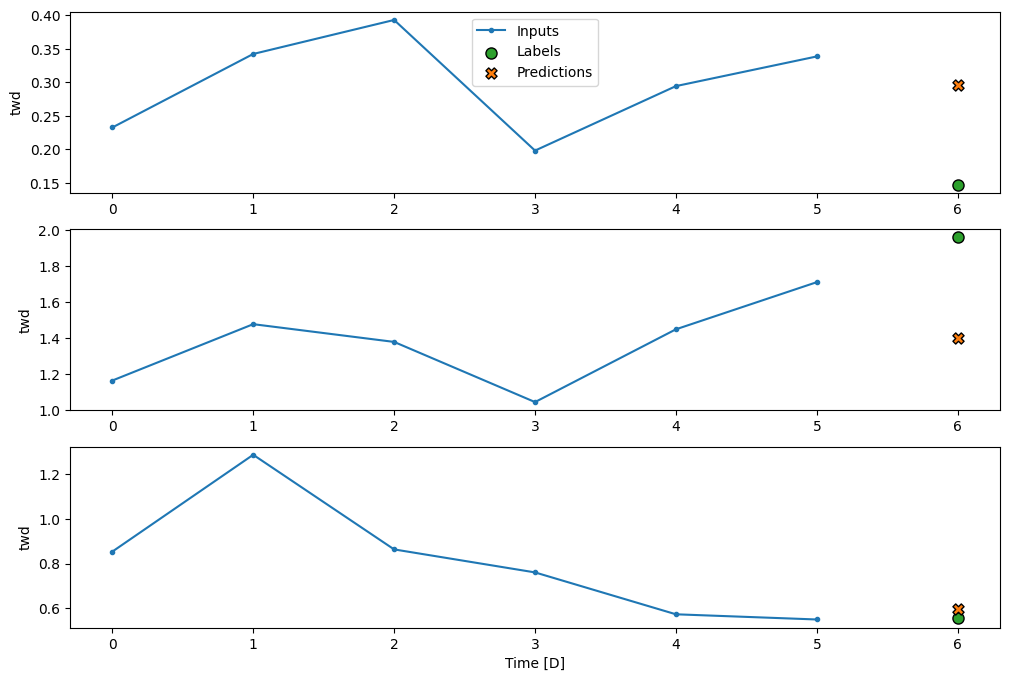

In [25]:
tfk = tfp.math.psd_kernels

class GPModel(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
        # Define kernel parameters
        self.amplitude = tf.Variable(1.0, trainable=True, dtype=tf.float32)
        self.length_scale = tf.Variable(1.0, trainable=True, dtype=tf.float32)
        
        # Define kernel
        self.kernel = tfk.ExponentiatedQuadratic(
            amplitude=self.amplitude,
            length_scale=self.length_scale
        )
        
    def call(self, inputs):
        if isinstance(inputs, tf.Tensor):
            inputs = tf.cast(inputs, tf.float32)
            
        # Get dimensions
        batch_size = tf.shape(inputs)[0]
        time_steps = tf.shape(inputs)[1]
        
        # Extract the target variable
        index_points = inputs[:, :, self.label_index]
        index_points = tf.reshape(index_points, [batch_size, time_steps, 1])
        
        # Create GP model
        gp = tfp.distributions.GaussianProcessRegressionModel(
            kernel=self.kernel,
            index_points=index_points,
            observation_index_points=index_points[:, :-1, :],  # All but last point
            observations=index_points[:, :-1, 0],  # All but last point
            observation_noise_variance=0.1,
            predictive_noise_variance=0.1
        )
        
        # Get predictions for the last time step
        mean = gp.mean()[:, -1:]  # Take last prediction
        return mean[:, :, tf.newaxis]  # Add feature dimension back

# Create model instance
gp_model = GPModel(label_index=column_indices['twd'])

# Create window and plot
w2 = WindowGenerator(input_width=6, label_width=1, shift=1,
                    label_columns=['twd'])
w2.plot(model=gp_model, plot_col='twd')

In [71]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['twd'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['twd']